# Kmeans
written by Eric Bridgeford and Theodor Marinov

In this notebook, we will investigate the K-means clustering implementation provided for our course project.

## Algorithm Basics

The algorithm used here is standard K-means with K-means++ inialization. At a high level, the algorithm for K-means is as follows:

### K-means

1. Initialize centers
2. while not converged:
    + Find the closest center for each data point.
    + for each center, average all of the points that are assigned and use this as the new center
    + check for convergence condition
3. end

Here, we define convergence as either the algorithm reaching the maximum number of iterations (defaulted to 100) or the sum from each point to its closest center not changing on a given iteration. To initialize the centers, we perform the following algorithm:

### K-means++ Initialization

1. choose one data point randomly.
2. while fewer than K centers chosen:
    + compute the squared distance from each point to its respective center.
    + normalize the squared distances to a pmf.
    + randomly choose a new center using the squared distance pmf.
3. end

Essentially, what we are doing is just choosing center points randomly, but evenly distributed throughout our data. K-means can perform poorly when the initial centers are too close or overlapping. This is not the focus of our paper, so we will try to keep the details brief. For more details, see the wikipedia page [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B).

In [1]:
%matplotlib inline
import numpy as np
from clustering import Kmeans, Spectral
from clustering.kernel import RBF_kernel
from clustering.utils import purity, plot_laplacian
import matplotlib.pyplot as plt


def sample_ball(r, dim=2, n=100, s=0):
    """
    A function to sample from the unit ball, given an input radius.
    """
    u = np.random.randn(dim, n)
    unorm = np.sqrt(np.sum(np.square(u), axis=0))*np.identity(n)
    return r*u.dot(np.linalg.pinv(unorm)) + s*np.random.randn(dim, n)

def kmeans_analyze(data, true_labels, nc, title=""):
    """
    A script that does data comparisons for kmeans and spectral clustering.
    
    **Positional Arguments:**\
        - data:
            - the data you want to cluster. should be FxFxn.
        - true_labels:
            - the labels for the data you want to cluster. Should be and n-vector
                that matches the ordering of the above data.
        - nc:
            - the number of classes
    """    
    km = Kmeans(K=nc)
    km.initialize(data)
    Cent = km.get_centers()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    scat1 = ax.scatter(data[0, :], data[1, :])
    scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
    ax.set_title('{}: Initialized'.format(title))
    ax.legend((scat1, scat2, scat3),
               ('Data', 'Initialized Centers'),
               loc='lower right')
    fig.tight_layout()
    fig.show()
    
    km.fit()
    Cent = km.get_centers()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scat1 = ax.scatter(data[0, :], data[1, :])
    scat3 = ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5)
    fig.legend((scat1, scat3),
               ('Data', 'Fitted Centers'),
               loc='lower right')
    ax.set_title('{}: Fitted'.format(title))
    fig.tight_layout()
    fig.show()
    
    pred_labels = km.get_assignments(data)

    # visualize
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scat = []
    lab = []
    for pred in np.unique(pred_labels):
        scat.append(ax.scatter(data[0, pred_labels == pred], data[1, pred_labels == pred]))
        lab.append("Predicted Class {}".format(pred))
    scat.append(ax.scatter(Cent[0, :], Cent[1, :], marker='*', linewidths=5))
    lab.append("Fitted Centers")
    ax.legend(tuple(scat), tuple(lab), loc='lower right')
    ax.set_title('{}: Predictions'.format(title))
    fig.tight_layout()
    fig.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(km.niter), km.dist[0:km.niter])
    ax.set_ylabel('Distance')
    ax.set_xlabel('Iteration Number')
    ax.set_title('Check of Convergence')
    fig.show()

    (p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
    print ("purity = {}".format(p))
    fig_conf.show()

# Simulation 1: Euclidian Center Separation

In this simulation, we have good euclidian center separation. As $K-$means attempts to maximize this notion of distance, we expect a good purity score here.

/home/eric/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


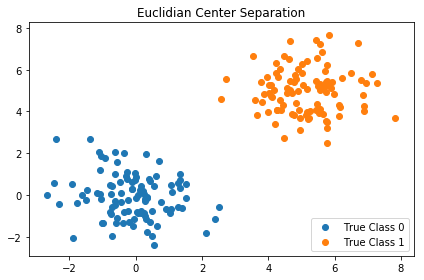

In [2]:

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 1*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 1*np.identity(d)
mean2 = 5*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Euclidian Center Separation')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

purity = 1.0


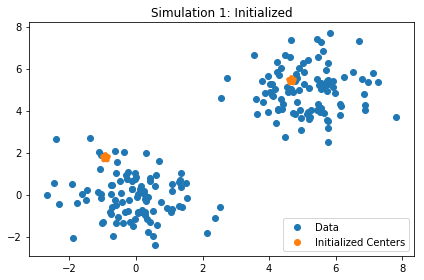

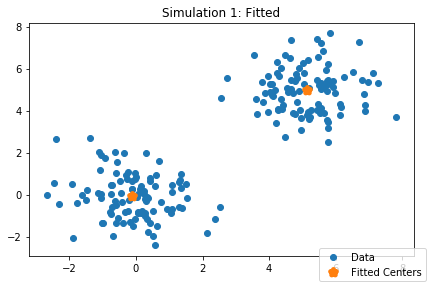

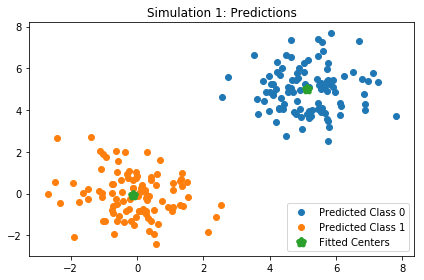

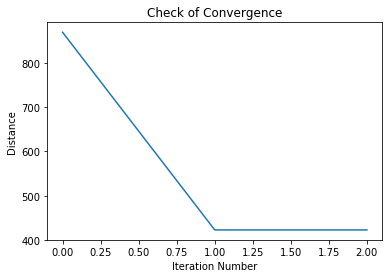

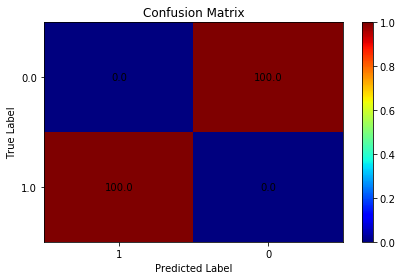

In [3]:
kmeans_analyze(data, true_labels, 2, title="Simulation 1")

As we can see in this simple example, our cluster initializations give us initial estimates in line with our intuition of finding cluster centers that are maximally separated by the squared distance. Fitting our parameters appears to optimize these good-first-estimates, allowing us to make perfect predictions on our data. As we can see, our model converges very rapidly towards the optimal solution, and performs perfectly with purity of 1.

# Simulation 2: Euclidian Center difference, Less Separation

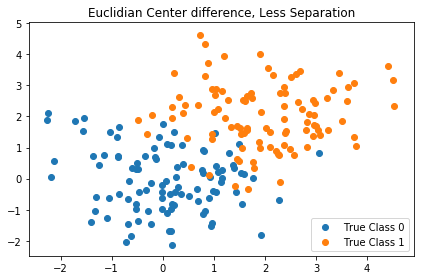

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from clustering import Kmeans

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 1*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 1*np.identity(d)
mean2 = 2*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Euclidian Center difference, Less Separation')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

purity = 0.925


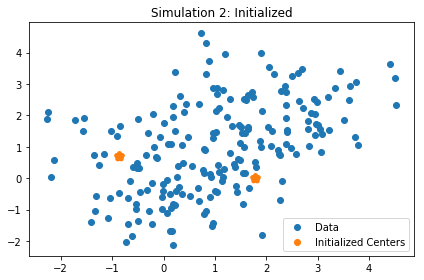

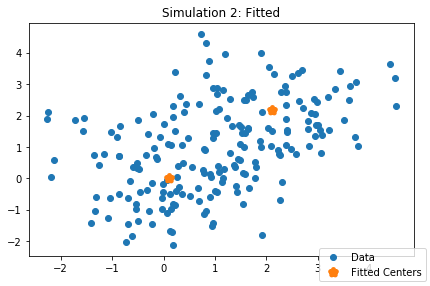

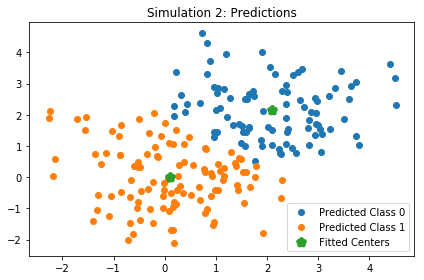

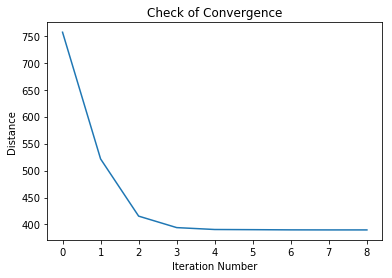

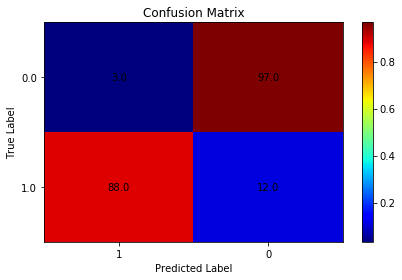

In [5]:
kmeans_analyze(data, true_labels, 2, title="Simulation 2")

Again, we see here that we obtain good performance for our slightly more difficult model where our data is no longer perfectly separable, but we still get $p=$0.91. 

# Simulation 3: Euclidian Center Inseparable Example

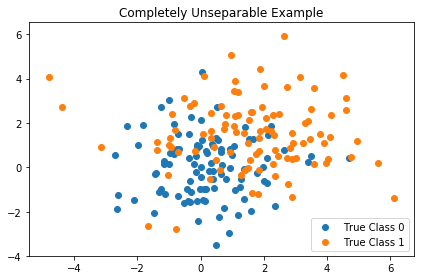

In [6]:

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 2*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 3*np.identity(d)
mean2 = 1.5*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Completely Unseparable Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

purity = 0.78


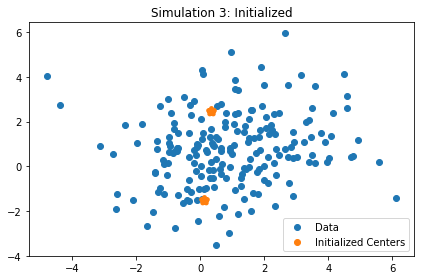

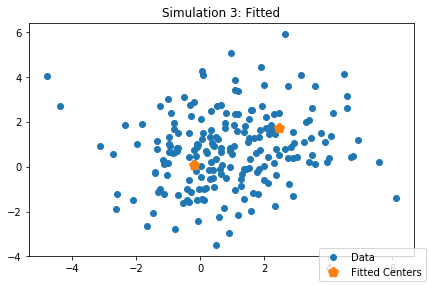

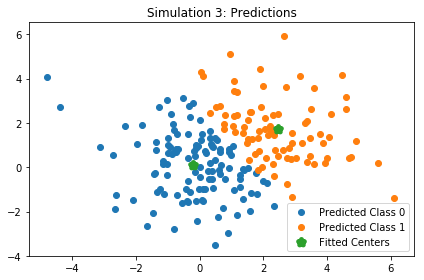

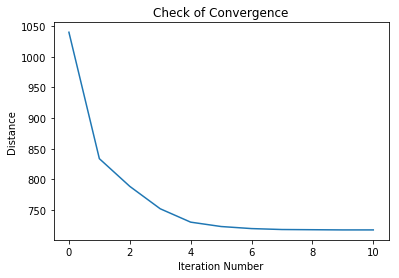

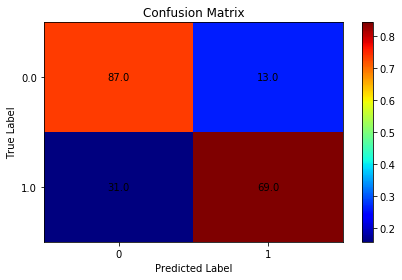

In [7]:
kmeans_analyze(data, true_labels, 2, title="Simulation 3")

Here, we can see that $K-$means begins to struggle fairly significantly to separate the data given that there is a good bit of overlap. It appears as though our cluster centers are fairly accurate, however, since we are just assigning each point to the closest cluster we lose a lot of the fine detail in the overlap. 

# Simulation 4: Multi Class with Linear Separability

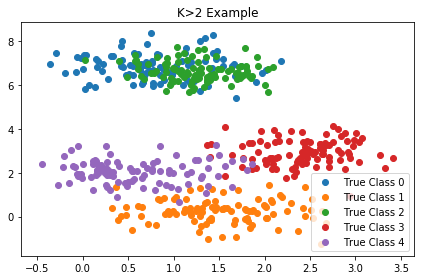

In [8]:

d=2  # 2d data sampled
n=100  # number of points to sample
K=5
xmean = np.random.uniform(low=0, high=7, size=K).tolist()
ymean = np.random.uniform(low=0, high=7, size=K).tolist()
variance = np.array([0.3, 0.3, 0.2, .3, 0.3]).tolist()

data_per_class = []
for i, (x, y, v) in enumerate(zip(xmean, ymean, variance)):
    data_per_class.append(np.random.multivariate_normal(mean = np.array([x, y]),
                                                        cov = v*np.identity(d),
                                                        size=n).transpose())

for i, d in enumerate(data_per_class):
    if i == 0:
        data = data_per_class[i]
        true_labels = i*np.ones((n,))
    else:
        data = np.hstack((data, data_per_class[i]))
        true_labels = np.concatenate((true_labels, i*np.ones((n,))))

idx = np.array(range(0, len(true_labels)))
np.random.shuffle(idx)
np.random.shuffle(idx)
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
label = []
scat = []
for i in range(0, K):
    scat.append(ax.scatter(data[0, true_labels == i],
                           data[1, true_labels == i]))
    label.append('True Class {}'.format(i))

ax.set_title('K>2 Example')
ax.legend(tuple(scat), tuple(label), loc='lower right')
fig.tight_layout()
fig.show()

purity = 0.836


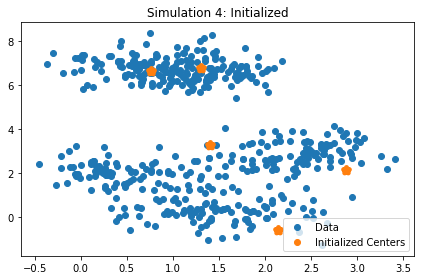

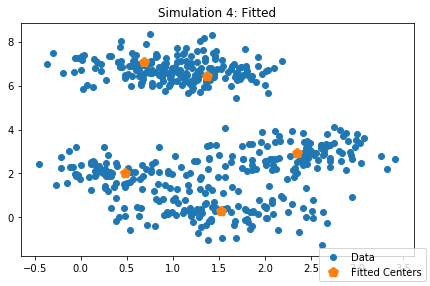

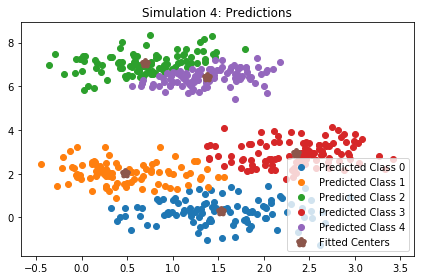

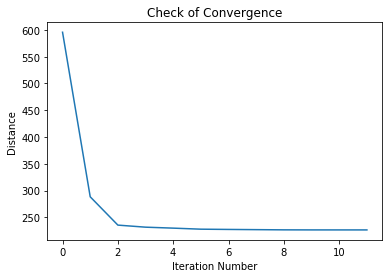

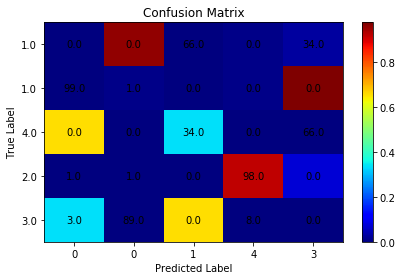

In [9]:
kmeans_analyze(data, true_labels, 5, title="Simulation 4")

Here, we can see that the algorithm does a surprisingly good job at finding all of the cluster centers nearly spot on despite relatively large overlap in the clusters, particularly the bottom cluster of 3. We aren't getting perfect classification by any means, but our estimations of centers is at least close. 

# Simulation 5: Radial Difference, K=2

In simulations $5 -> 7$, we see varieties of radially separated clusters. As $K-$means has no way to handle this notion (it only considers euclidian center separation), we expect (and find) that $K-$means performs incredibly poorly on all examples. 

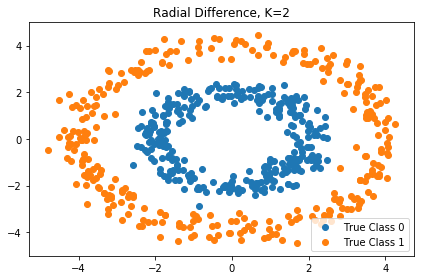

In [10]:

n=300
dim=2
s=0.3
data1 = sample_ball(r=2, dim=dim, n=n, s=s)
data2 = sample_ball(r=4, dim=dim, n=n, s=s)
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
data = np.hstack((data1, data2))
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Radial Difference, K=2')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

purity = 0.533333333333


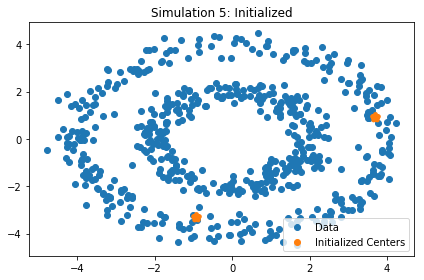

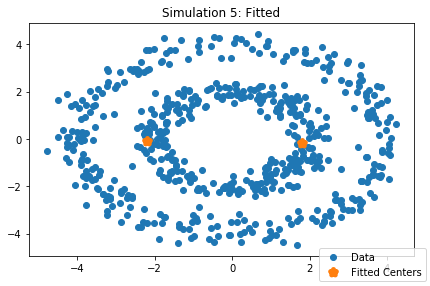

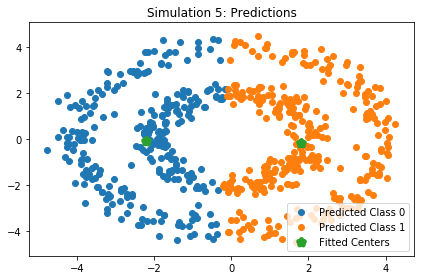

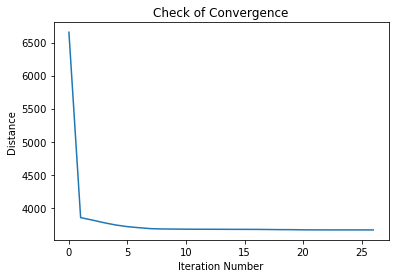

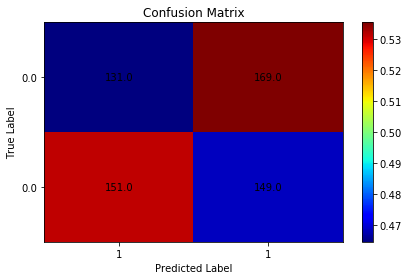

In [11]:
kmeans_analyze(data, true_labels, 2, title="Simulation 5")

# Simulation 6: Radial Difference, K=3

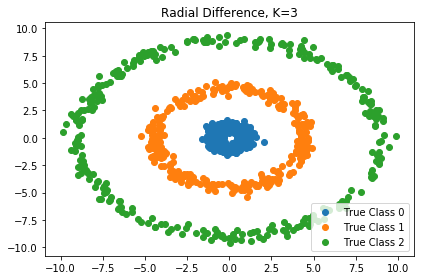

In [12]:
n=300
dim=2
s=0.3
data1 = sample_ball(r=1, dim=dim, n=n, s=s)
data2 = sample_ball(r=4.5, dim=dim, n=n, s=s)
data3 = sample_ball(r=9, dim=dim, n=n, s=s)
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,)),
                              2*np.ones((n,))))
data = np.hstack((data1, data2, data3))
idx = range(0, len(true_labels))
np.random.shuffle(idx)
#randomly permute
#data = data[:, idx]
#true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
scat3 = ax.scatter(data[0, true_labels == 2], data[1, true_labels == 2])
ax.set_title('Radial Difference, K=3')
ax.legend((scat1, scat2, scat3), ('True Class 0', 'True Class 1', 'True Class 2'),
          loc='lower right')
fig.tight_layout()
fig.show()

purity = 0.575555555556


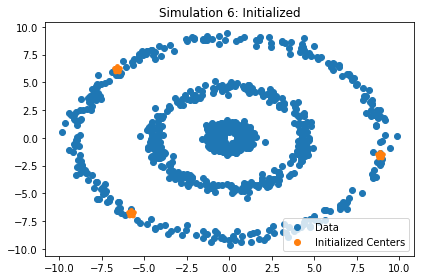

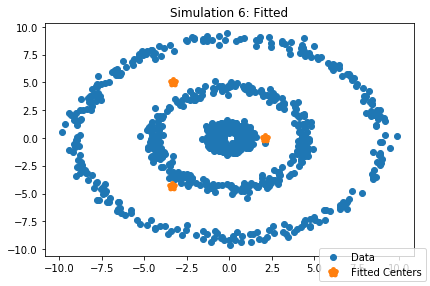

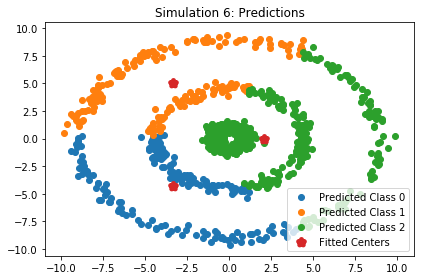

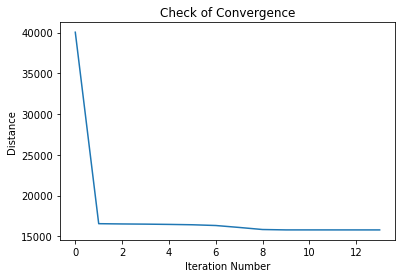

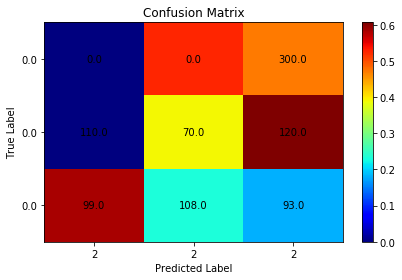

In [13]:
kmeans_analyze(data, true_labels, 3, title="Simulation 6")

# Simulation 7: Non-Concentric Spheres

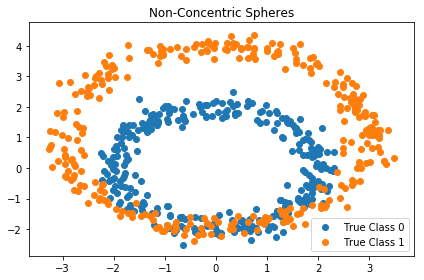

In [14]:
n=300
dim=2
s=0.2
data1 = sample_ball(r=2, dim=dim, n=n, s=s)
new_mean = np.identity(dim)
new_mean[0] = 0
data2 = sample_ball(r=3, dim=dim, n=n, s=s) + new_mean.dot(np.ones((dim, n)))
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
data = np.hstack((data1, data2))
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Non-Concentric Spheres')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

purity = 0.563333333333


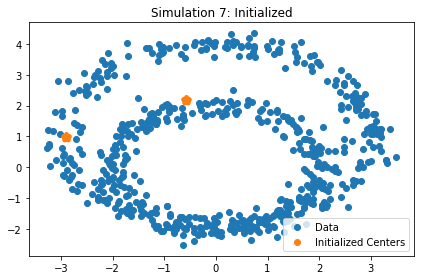

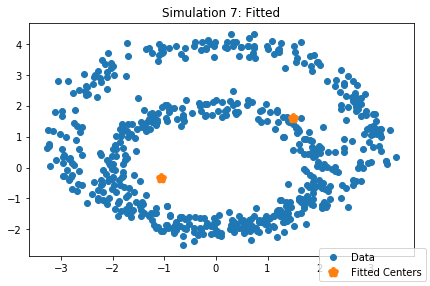

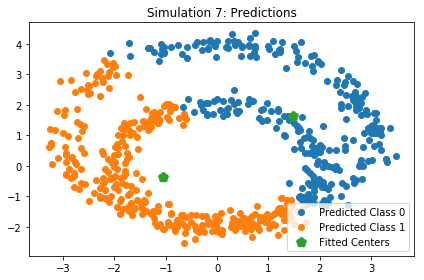

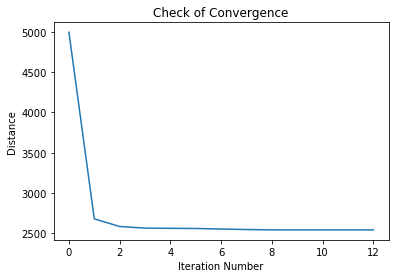

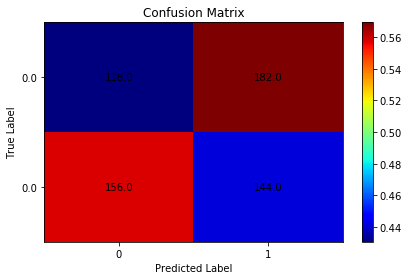

In [15]:
kmeans_analyze(data, true_labels, 2, title="Simulation 7")

# Simulation 8: 